In [1]:
#open file and import important libraries
#import tarfile
import os.path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

if os.path.isfile("adult-all.csv"):
    adult_df = pd.read_csv("adult-all.csv", names=["age", "work-class", "fnlwgt", "education", "education-num", 
                            "marital-status", "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
                            "hours-per-week", "native-country", "income"], na_values = " ?", low_memory=False)
else:
    print("Cannot find file")
    exit()

In [2]:
###PRE-PROCESSING
#drop non-orderable categorical variables which can't be used in the repair process
adult_df.drop(["education", "work-class", "marital-status", "occupation", "relationship", "native-country"], 
              axis=1, inplace=True)

In [3]:
print(adult_df[["race", "sex", "age"]].head(1))

    race   sex  age
0  White  Male   39


In [4]:
#encode categorical variables
adult_df = adult_df.replace("Male", 1)
adult_df = adult_df.replace("Female", 0)
adult_df = adult_df.replace("<=50K", 0)
adult_df = adult_df.replace(">50K", 1)
adult_df = adult_df.replace("White", 1)
adult_df["race"] = adult_df["race"].replace(to_replace=r"[^0-1]", value=0, regex=True)

print(adult_df[["race", "sex", "income"]].head(1))

   race  sex  income
0     1    1       0


In [5]:
print(adult_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   fnlwgt          48842 non-null  int64
 2   education-num   48842 non-null  int64
 3   race            48842 non-null  int64
 4   sex             48842 non-null  int64
 5   capital-gain    48842 non-null  int64
 6   capital-loss    48842 non-null  int64
 7   hours-per-week  48842 non-null  int64
 8   income          48842 non-null  int64
dtypes: int64(9)
memory usage: 3.4 MB
None


In [6]:
#create columns for each protected group
new_col_names = ["white-male", "white-female", "non-white-male", "non-white-female"]
new_cols = np.zeros((adult_df.shape[0], 4))
white_male_age = []

for index, row in adult_df.iterrows():
    if row["race"] == 1 and row["sex"] == 1:
        new_cols[index][0] = 1
    elif row["race"] == 1 and row["sex"] == 0:
        new_cols[index][1] = 1
    elif row["race"] == 0 and row["sex"] == 1:
        new_cols[index][2] = 1
    elif row["race"] == 0 and row["sex"] == 0:
        new_cols[index][3] = 1
    else:
        print("invalid")
        
new_cols_df = pd.DataFrame(data=new_cols, columns = new_col_names)
print(adult_df[["race", "sex"]].head())
print(new_cols_df.head())

   race  sex
0     1    1
1     1    1
2     1    1
3     0    1
4     0    0
   white-male  white-female  non-white-male  non-white-female
0         1.0           0.0             0.0               0.0
1         1.0           0.0             0.0               0.0
2         1.0           0.0             0.0               0.0
3         0.0           0.0             1.0               0.0
4         0.0           0.0             0.0               1.0


In [7]:
adult_df = pd.concat([adult_df, new_cols_df], axis=1)
print(adult_df.head())

   age  fnlwgt  education-num  race  sex  capital-gain  capital-loss  \
0   39   77516             13     1    1          2174             0   
1   50   83311             13     1    1             0             0   
2   38  215646              9     1    1             0             0   
3   53  234721              7     0    1             0             0   
4   28  338409             13     0    0             0             0   

   hours-per-week  income  white-male  white-female  non-white-male  \
0              40       0         1.0           0.0             0.0   
1              13       0         1.0           0.0             0.0   
2              40       0         1.0           0.0             0.0   
3              40       0         0.0           0.0             1.0   
4              40       0         0.0           0.0             0.0   

   non-white-female  
0               0.0  
1               0.0  
2               0.0  
3               0.0  
4               1.0  


In [8]:
#create dataframes for each sensitive group
white_male_df = adult_df[adult_df["white-male"] == 1]
white_male_no = white_male_df.shape[0]
white_female_df = adult_df[adult_df["white-female"] == 1]
white_female_no = white_female_df.shape[0]
non_white_male_df = adult_df[adult_df["non-white-male"] == 1]
non_white_male_no = non_white_male_df.shape[0]
non_white_female_df = adult_df[adult_df["non-white-female"] == 1]
non_white_female_no = non_white_female_df.shape[0]
print("number of entries in sensitive groups: ", white_male_no, white_female_no, non_white_male_no, non_white_female_no)

number of entries in sensitive groups:  28735 13027 3915 3165


In [9]:
#create sorted lists to be used in the repair process
sorted_lists = {}
sorted_indices = {}
protected_lists = {}
protected_lists_indices = {}
columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for column in columns:    
    protected_list = {}
    protected_list_indice = {}
    wmdf_s = white_male_df[column].sort_values()
    protected_list["white-male"] = list(wmdf_s)
    protected_list_indice["white-male"] = list(wmdf_s.index.values)
    wfdf_s = white_female_df[column].sort_values()
    protected_list["white-female"] = list(wfdf_s)
    protected_list_indice["white-female"] = list(wfdf_s.index.values)
    nmdf_s = non_white_male_df[column].sort_values()
    protected_list["non-white-male"] = list(nmdf_s)
    protected_list_indice["non-white-male"] = list(nmdf_s.index.values)
    nfdf_s = non_white_female_df[column].sort_values()
    protected_list["non-white-female"] = list(nfdf_s)
    protected_list_indice["non-white-female"] = list(nfdf_s.index.values)
    
    protected_lists[column] = protected_list
    protected_lists_indices[column] = protected_list_indice
    
    sorted_list = []
    sorted_indice = {}

    sorted_list = list(adult_df[column])
    sorted_list.sort()

    sorted_list = list(dict.fromkeys(sorted_list))
    sorted_lists[column] = sorted_list

    ind = 0
    for no in sorted_list:
        sorted_indice[no] = ind
        ind += 1

    sorted_indices[column] = sorted_indice

In [10]:
print("example entry before repair: ")
print(adult_df.iloc[30781])

example entry before repair: 
age                     66.0
fnlwgt              186061.0
education-num           10.0
race                     0.0
sex                      0.0
capital-gain             0.0
capital-loss          4356.0
hours-per-week          40.0
income                   0.0
white-male               0.0
white-female             0.0
non-white-male           0.0
non-white-female         1.0
Name: 30781, dtype: float64


In [11]:
def my_median(list_):
    if len(list_) % 2 != 0:
        index = int((len(list_) / 2) - 0.5)
        return list_[index]
    else:
        index = int((len(list_)/2) - 1)
        return list_[index]

In [12]:
#implementation of the repair process 
lambda_ = 0.8   #how strongly to repair, between 0 and 1
repair_type = "combinatorial"   #repair type, combinatorial or geometric
number_quantiles = non_white_female_no
columns = ["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week"]

for column in columns:
    i, j, k, l = 0, 0, 0, 0
    white_male_quantiles = np.array_split(protected_lists[column]["white-male"], number_quantiles)
    white_female_quantiles = np.array_split(protected_lists[column]["white-female"], number_quantiles)
    non_white_male_quantiles = np.array_split(protected_lists[column]["non-white-male"], number_quantiles)
    non_white_female_quantiles = np.array_split(protected_lists[column]["non-white-female"], number_quantiles)
    
    for quantile_num in range(number_quantiles):
        median_list = []
        white_male_median = my_median(white_male_quantiles[quantile_num])
        median_list.append(white_male_median)
        white_female_median = my_median(white_female_quantiles[quantile_num])
        median_list.append(white_female_median)
        non_white_male_median = my_median(non_white_male_quantiles[quantile_num])
        median_list.append(non_white_male_median)
        non_white_female_median = my_median(non_white_female_quantiles[quantile_num])
        median_list.append(non_white_female_median)
        
        median_list.sort()
        target = my_median(median_list)
        index_target = sorted_indices[column][target]
        
        for value in white_male_quantiles[quantile_num]:
            index_original = sorted_indices[column][value]
            repair_index = int(index_original + (lambda_*(index_target - index_original)))
            if repair_type == "combinatorial":
                final_value = sorted_lists[column][repair_index]
            else:
                final_value = ((1-lambda_)*value) + (lambda_*target)
            protected_lists[column]["white-male"][i] = final_value
            i+=1

        for value in white_female_quantiles[quantile_num]:
            index_original = sorted_indices[column][value]
            repair_index = int(index_original + (lambda_*(index_target - index_original)))
            if repair_type == "combinatorial":
                final_value = sorted_lists[column][repair_index]
            else:
                final_value = ((1-lambda_)*value) + (lambda_*target)
            protected_lists[column]["white-female"][j] = final_value
            j+=1
            
        for value in non_white_male_quantiles[quantile_num]:
            index_original = sorted_indices[column][value]
            repair_index = int(index_original + (lambda_*(index_target - index_original)))
            if repair_type == "combinatorial":
                final_value = sorted_lists[column][repair_index]
            else:
                final_value = ((1-lambda_)*value) + (lambda_*target)
            protected_lists[column]["non-white-male"][k] = final_value
            k+=1
            
        for value in non_white_female_quantiles[quantile_num]:
            index_original = sorted_indices[column][value]
            repair_index = int(index_original + (lambda_*(index_target - index_original)))
            if repair_type == "combinatorial":
                final_value = sorted_lists[column][repair_index]
            else:
                final_value = ((1-lambda_)*value) + (lambda_*target)
            protected_lists[column]["non-white-female"][l] = final_value
            l+=1
            

In [13]:
#apply repaired columns into original dataframe
for column_ in protected_lists:
    for key in protected_lists[column_]:
        for i in range(len(protected_lists[column_][key])):
            cell_index = protected_lists_indices[column_][key][i]
            cell_value = protected_lists[column_][key][i]
            adult_df.at[cell_index, column_] = cell_value

print("example column after repair: ")
print(adult_df.iloc[30781])

example column after repair: 
age                     67.0
fnlwgt              185057.0
education-num           10.0
race                     0.0
sex                      0.0
capital-gain             0.0
capital-loss          3175.0
hours-per-week          40.0
income                   0.0
white-male               0.0
white-female             0.0
non-white-male           0.0
non-white-female         1.0
Name: 30781, dtype: float64


In [14]:
#drop sensitive columns after repair
adult_df.drop(["white-male", "white-female", "non-white-male", "non-white-female"], axis=1, inplace=True)

In [15]:
print(adult_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48842 entries, 0 to 48841
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   age             48842 non-null  int64
 1   fnlwgt          48842 non-null  int64
 2   education-num   48842 non-null  int64
 3   race            48842 non-null  int64
 4   sex             48842 non-null  int64
 5   capital-gain    48842 non-null  int64
 6   capital-loss    48842 non-null  int64
 7   hours-per-week  48842 non-null  int64
 8   income          48842 non-null  int64
dtypes: int64(9)
memory usage: 3.4 MB
None


In [16]:
x_all = adult_df[["age", "fnlwgt", "education-num", "capital-gain", "capital-loss", "hours-per-week", "race", "sex"]]
y_all = adult_df["income"]
print(x_all.shape, y_all.shape)

(48842, 8) (48842,)


In [17]:
#split data into train and test set
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split(x_all, y_all, test_size=0.3, random_state=0)

#don't use race and sex to train model
race_sex_df = test_X[["race", "sex"]].copy()

train_X = train_X.drop(["race", "sex"], axis=1)
test_X = test_X.drop(["race", "sex"], axis=1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(34189, 6) (34189,) (14653, 6) (14653,)


In [18]:
###FAIR MODEL IMPLEMENTATION
from sklearn.linear_model import LogisticRegression

#logistic regression model conventional implementation
logistic_regression_model = LogisticRegression(C=0.1, penalty="l2", solver="liblinear", max_iter=10000)
logistic_regression_model.fit(train_X, train_y)

logistic_y_pred = logistic_regression_model.predict(test_X)
pred_train = logistic_regression_model.predict(train_X)

from sklearn.metrics import accuracy_score

print("logistic regression model accuracy score on training set: ", accuracy_score(train_y, pred_train))
print("logistic regression model accuracy score on test set: ", accuracy_score(test_y, logistic_y_pred))

logistic regression model accuracy score on training set:  0.7952265348503905
logistic regression model accuracy score on test set:  0.8015423462772129


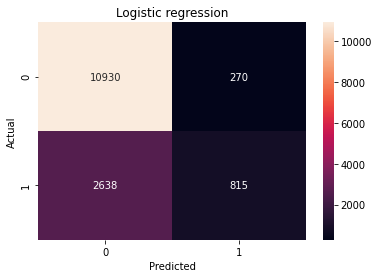

model utility:  0.6059597503206322


In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

#logistic regression confusion matrix
log_matrix = confusion_matrix(test_y, logistic_y_pred)

sns.heatmap(log_matrix, fmt="", annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title('Logistic regression')
plt.show()

#calculate utility (1 - balanced error rate)
TN, FP = log_matrix[0][0], log_matrix[0][1]
FN, TP = log_matrix[1][0], log_matrix[1][1]
BER = 0.5 * ((FN / (FN + TP)) + (FP/(FP + TN)))
utility = 1 - BER
print("model utility: ", utility)

In [20]:
#add race and sex back into dataframe
test_X = pd.concat([test_X, race_sex_df], axis=1)

#reindex
test_X.index = np.arange(len(test_X))
test_y.index = np.arange(len(test_y))

In [21]:
#calculate zemel fairness and disparate impact for race and sex

p_attr = ["race", "sex"]

for attr in p_attr:
    white_test_samples = 0
    white_pos_samples = 0
    non_white_test_samples = 0
    non_white_pos_samples = 0
    for index, row in test_X.iterrows():
        if row[attr] == 1:
            white_test_samples += 1
            if logistic_y_pred[index] == 1:
                white_pos_samples += 1
        elif row[attr] == 0:
            non_white_test_samples += 1
            if logistic_y_pred[index] == 1:
                non_white_pos_samples += 1
        else:
            print("Invalid")
    
    print(attr, ":")
    print("priveleged samples: ", white_test_samples, "        posotive: ", white_pos_samples)
    print("non-priveleged samples: ", non_white_test_samples, "     posotive: ", non_white_pos_samples, "\n")

    pr_white_pos = white_pos_samples/white_test_samples
    pr_non_white_pos = non_white_pos_samples/non_white_test_samples
    zemel_fairness = pr_white_pos - pr_non_white_pos
    disparate_impact = pr_non_white_pos/pr_white_pos
    if attr == "race":
        race_zemel = 1 - zemel_fairness
        race_DI = disparate_impact
    else:
        sex_zemel = 1 - zemel_fairness
        sex_DI = disparate_impact
 
    print(attr, "zemel fairness: ", 1 - zemel_fairness, "\n")
    print(attr, "disparate impact: ", disparate_impact, "\n")

race :
priveleged samples:  12580         posotive:  942
non-priveleged samples:  2073      posotive:  143 

race zemel fairness:  0.9941013883552404 

race disparate impact:  0.921226608820514 

sex :
priveleged samples:  9780         posotive:  746
non-priveleged samples:  4873      posotive:  339 

sex zemel fairness:  0.9932888832375046 

sex disparate impact:  0.9120177990117897 



In [22]:
white_male_samples = 0
white_male_pos = 0
non_white_female_s = 0
non_white_pos = 0

for index, row in test_X.iterrows():
    if row["sex"] == 1 and row["race"] == 1:
        white_male_samples += 1
        if logistic_y_pred[index] == 1:
            white_male_pos += 1
    elif row["sex"] == 0 and row["race"] == 0:
        non_white_female_s += 1
        if logistic_y_pred[index] == 1:
            non_white_pos += 1

pr_white_pos = white_male_pos/white_male_samples
pr_non_white_pos = non_white_pos/non_white_female_s
zemel_fairness = pr_white_pos - pr_non_white_pos
disparate_impact = pr_non_white_pos/pr_white_pos

print("race and sex zemel fairness: ", 1 - zemel_fairness, "\n")
print("race and sex disparate impact: ", disparate_impact, "\n \n")
fairness = ((1-zemel_fairness) + disparate_impact + race_zemel + race_DI + sex_zemel + sex_DI)/6
print("final fairness: ", fairness, "(average of all fairness metrics)")

race and sex zemel fairness:  0.9840213944774919 

race and sex disparate impact:  0.7907239781261782 
 

final fairness:  0.9325633420047864 (average of all fairness metrics)
